## data generation

In [1]:
from locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse
import GraphNOTEARS
import notears_torch_version
import lasso
import dynotears
import utils as ut
import matplotlib.pyplot as plt



#device = torch.device("cuda:0")
device = torch.device("cuda")

def data_pre(n, d, s0, w_graph_type, p_graph_type, sem_type):

    w_true = ut.simulate_dag(d, s0, w_graph_type)#binary W

    w_mat = ut.simulate_parameter(w_true)#weighted W


    adj1 = ut.generate_adj(n) #A

    num_step = 2 #cannot work if num_step=1
    Xbase = []

    #Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)#X_0
    p1_mat=w_mat
    p1_true=w_true
    #p1_mat, p1_true = ut.generate_tri(d, p_graph_type, low_value=0.0, high_value=2)#P
 

    for i in range(num_step):
        #Xbase1 = ut.simulate_linear_sem_with_P(w_mat, p1_mat, adj1@Xbase1, n, sem_type, noise_scale=1)#X_1,X_2...
        ##no time-dependency
        Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)#X_0
        Xbase.append(Xbase1)

    return Xbase, adj1, w_true,w_mat, p1_true, p1_mat

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

import utils as ut
ut.set_random_seed(123)

n = 50

d = 5

w_graph_type = 'ER'
p_graph_type = 'ER' 
sem_type = 'exp'
s0 =  d

In [3]:
Xlags, adj1, w_true,w_mat, p1_true, p1_mat = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type)

In [4]:
w_true

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

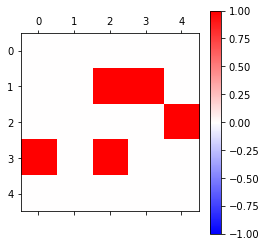

In [5]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_true,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

In [6]:
w_mat

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.56 , -0.819,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.785],
       [ 0.938,  0.   , -0.844,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [7]:
w_mat[2,0]=w_mat[3,0]
w_mat[3,0]=0

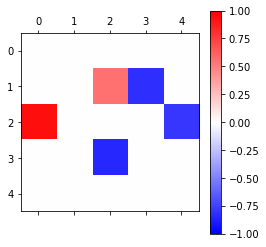

In [8]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

In [9]:
w_mat

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.56 , -0.819,  0.   ],
       [ 0.938,  0.   ,  0.   ,  0.   , -0.785],
       [ 0.   ,  0.   , -0.844,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [10]:
np.shape(Xlags)

(2, 50, 5)

In [11]:
adj1.shape

(50, 50)

## testing data

In [12]:
w_test_mat=w_mat.copy()
w_test_mat[2,0]=-1.0

In [13]:
w_test_mat

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.56 , -0.819,  0.   ],
       [-1.   ,  0.   ,  0.   ,  0.   , -0.785],
       [ 0.   ,  0.   , -0.844,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [14]:
def data_pre_test(n, w_mat,sem_type):
    Xbase = []
    num_step = 2
    for i in range(num_step):
        Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)#X_0
        Xbase.append(Xbase1)

    return Xbase

In [15]:
Xlags_test= data_pre_test(n,w_test_mat, sem_type)

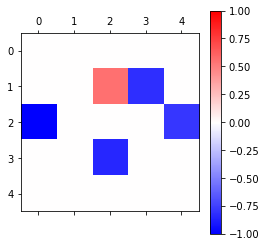

In [16]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_test_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

## fit the causal graph

In [17]:
Xlags_torch = torch.Tensor(np.array(Xlags))
adj1_torch = torch.Tensor(adj1)
model_1 = GraphNOTEARS.model_p1_MLP(dims=[d, n, 1], bias=True)
#model_1.to(device)
W_est_1, P1_est_1 = GraphNOTEARS.linear_model(model_1, Xlags_torch, adj1_torch,  lambda1 = 0.01, lambda2 = 0.01, lambda3 = 0.01)

rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rh

h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rh

h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rho < rho_max: 1.0 1e+16
h inf
rh

h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.0 1e+16
h tensor(0.0214)
rho < rho_max: 1.

h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.

rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_max: 10.0 1e+16
h tensor(0.0214)
rho < rho_m

h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.0045)
rho < rho_max: 10.0 1e+16
h tensor(0.

h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 

h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 100.0 1e+16
h tensor(0.0045)
rho < rho_max: 

h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0.0009)
rho < rho_max: 1000.0 1e+16
h tensor(0

h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(0.0002)
rho < rho_max: 10000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 10000.0 1e+16
h tensor(4.3013e-05)
rho < rho

h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_max: 100000.0 1e+16
h tensor(4.3013e-05)
rho < rho_

h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 1000000.0 1e+16
h tensor(2.3

h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0 1e+16
h tensor(2.3380e-06)
rho < rho_max: 10000000.0

h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < rho_max: 100000000.0 1e+16
h tensor(4.3620e-07)
rho < r

h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.0 1e+16
h tensor(2.4148e-08)
rho < rho_max: 10000000000.

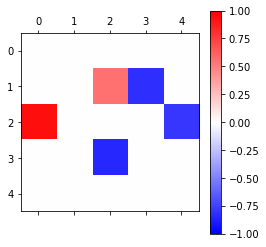

In [18]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

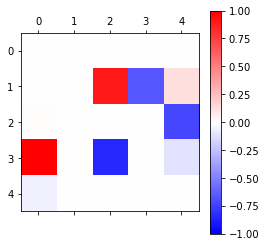

In [19]:
##Estimated W
import matplotlib.pyplot as plt
plt.matshow(W_est_1,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

## process data to gnn format

In [20]:
import networkx as nx
import dgl

Using backend: pytorch


In [21]:
def get_node_feature(Xlags,node_num):
    for num_lags in range(1):
        if num_lags==0:
            X_feature=Xlags[num_lags][node_num]
        else:
            X_feature=np.append(X_feature,Xlags[num_lags][node_num])##shape num_lags*5 (250)
    return(X_feature)

In [22]:
def get_node_feature_sub(Xlags,node_num):
    for num_lags in range(1):
        if num_lags==0:
            X_feature=Xlags[num_lags][node_num][[1,2,3,4]]
        else:
            X_feature=np.append(X_feature,Xlags[num_lags][node_num][[1,2,3,4]])##shape num_lags*5 (250)
    return(X_feature)

In [23]:
def to_binary(x):
    if x>0.5:
        return 1
    else:
        return 0

In [24]:
G = nx.from_numpy_array(adj1)

In [25]:
n

50

In [26]:
import random
ut.set_random_seed(123)
valid_list=random.sample(range(50), 20) ##node list for validation
labels=[]
G = nx.from_numpy_array(adj1)
for node_num in range(n):
    G.nodes[node_num]['feature']=get_node_feature(Xlags,node_num)[:-1]
    
    G.nodes[node_num]['label']=to_binary(get_node_feature(Xlags,node_num)[-1])
    
    labels.append(G.nodes[node_num]['label'])
    if node_num in valid_list:
        G.nodes[node_num]['train_mask']=False
        G.nodes[node_num]['valid_mask']=True
    else:
        G.nodes[node_num]['train_mask']=True
        G.nodes[node_num]['valid_mask']=False

In [27]:
g = dgl.from_networkx(G, node_attrs=['feature','label','train_mask','valid_mask'])

D:\Anaconda\lib\site-packages\dgl\backend\pytorch\tensor.py:40: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)



In [28]:
g

Graph(num_nodes=50, num_edges=284,
      ndata_schemes={'feature': Scheme(shape=(4,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'valid_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [29]:
G_test = nx.from_numpy_array(adj1)
import random
ut.set_random_seed(123)
valid_list=random.sample(range(50), 20) ##node list for validation
labels=[]
G_test = nx.from_numpy_array(adj1)
for node_num in range(n):
    G_test.nodes[node_num]['feature']=get_node_feature(Xlags_test,node_num)[:-1]
    
    G_test.nodes[node_num]['label']=to_binary(get_node_feature(Xlags_test,node_num)[-1])
    
    labels.append(G_test.nodes[node_num]['label'])
    if node_num in valid_list:
        G_test.nodes[node_num]['train_mask']=False
        G_test.nodes[node_num]['valid_mask']=True
    else:
        G_test.nodes[node_num]['train_mask']=True
        G_test.nodes[node_num]['valid_mask']=False
g_test = dgl.from_networkx(G_test, node_attrs=['feature','label','train_mask','valid_mask'])
g_test

Graph(num_nodes=50, num_edges=284,
      ndata_schemes={'feature': Scheme(shape=(4,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'valid_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

# only four degrees

In [30]:
G_1 = nx.from_numpy_array(adj1)
import random
ut.set_random_seed(123)
valid_list=random.sample(range(50), 20) ##node list for validation
labels=[]
G_1= nx.from_numpy_array(adj1)
for node_num in range(n):
    G_1.nodes[node_num]['feature']=get_node_feature_sub(Xlags,node_num)[:-1]
    
    G_1.nodes[node_num]['label']=to_binary(get_node_feature_sub(Xlags,node_num)[-1])
    
    labels.append(G_1.nodes[node_num]['label'])
    if node_num in valid_list:
        G_1.nodes[node_num]['train_mask']=False
        G_1.nodes[node_num]['valid_mask']=True
    else:
        G_1.nodes[node_num]['train_mask']=True
        G_1.nodes[node_num]['valid_mask']=False

In [31]:
g_1 = dgl.from_networkx(G_1, node_attrs=['feature','label','train_mask','valid_mask'])
g_1 

Graph(num_nodes=50, num_edges=284,
      ndata_schemes={'feature': Scheme(shape=(3,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'valid_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [32]:
G_1_test = nx.from_numpy_array(adj1)
import random
ut.set_random_seed(123)
valid_list=random.sample(range(50), 20) ##node list for validation
labels=[]
G_1_test = nx.from_numpy_array(adj1)
for node_num in range(n):
    G_1_test.nodes[node_num]['feature']=get_node_feature_sub(Xlags,node_num)[:-1]
    
    G_1_test.nodes[node_num]['label']=to_binary(get_node_feature_sub(Xlags,node_num)[-1])
    
    labels.append(G_1_test.nodes[node_num]['label'])
    if node_num in valid_list:
        G_1_test.nodes[node_num]['train_mask']=False
        G_1_test.nodes[node_num]['valid_mask']=True
    else:
        G_1_test.nodes[node_num]['train_mask']=True
        G_1_test.nodes[node_num]['valid_mask']=False
g1_test = dgl.from_networkx(G_1_test, node_attrs=['feature','label','train_mask','valid_mask'])
g1_test

Graph(num_nodes=50, num_edges=284,
      ndata_schemes={'feature': Scheme(shape=(3,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'valid_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

## GCN

In [33]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

In [34]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(4, 3)
        self.layer2 = GCNLayer(3, 2)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x


In [108]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [38]:
import torch.nn.functional as F
import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import random
ut.set_random_seed(123)
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

net = Net()
print(net)

features = g.ndata['feature']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
valid_mask = g.ndata['valid_mask']
###test
features_test = g_test.ndata['feature']
labels_test = g_test.ndata['label']

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
for epoch in range(500):
    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_acc = evaluate(net, g, features, labels, train_mask)
    test_acc = evaluate(net, g_test, features_test, labels_test, valid_mask)
    print(
        "Epoch {:05d} | Loss {:.4f}| Train Acc {:.4f} | Test Acc {:.4f}".format(
            epoch, loss.item(), train_acc, test_acc
        )
    )

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=4, out_features=3, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=3, out_features=2, bias=True)
  )
)
Epoch 00000 | Loss 3.3185| Train Acc 0.6667 | Test Acc 0.6000
Epoch 00001 | Loss 2.9305| Train Acc 0.7000 | Test Acc 0.5000
Epoch 00002 | Loss 2.5637| Train Acc 0.7000 | Test Acc 0.5000
Epoch 00003 | Loss 2.2207| Train Acc 0.7000 | Test Acc 0.3500
Epoch 00004 | Loss 1.9102| Train Acc 0.7000 | Test Acc 0.3000
Epoch 00005 | Loss 1.6377| Train Acc 0.7000 | Test Acc 0.3000
Epoch 00006 | Loss 1.3984| Train Acc 0.7000 | Test Acc 0.2500
Epoch 00007 | Loss 1.2001| Train Acc 0.6000 | Test Acc 0.2000
Epoch 00008 | Loss 1.0417| Train Acc 0.6000 | Test Acc 0.3000
Epoch 00009 | Loss 0.9197| Train Acc 0.5667 | Test Acc 0.3000
Epoch 00010 | Loss 0.8309| Train Acc 0.6333 | Test Acc 0.3000
Epoch 00011 | Loss 0.7733| Train Acc 0.6000 | Test Acc 0.2500
Epoch 00012 | Loss 0.7383| Train Acc 0.5333 | Test Acc 0.3000
Epoch 000

Epoch 00139 | Loss 0.3740| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00140 | Loss 0.3721| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00141 | Loss 0.3703| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00142 | Loss 0.3684| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00143 | Loss 0.3664| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00144 | Loss 0.3645| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00145 | Loss 0.3627| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00146 | Loss 0.3608| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00147 | Loss 0.3588| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00148 | Loss 0.3568| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00149 | Loss 0.3548| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00150 | Loss 0.3528| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00151 | Loss 0.3510| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00152 | Loss 0.3490| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00153 | Loss 0.3470| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00154 | Loss 0.3450| Train Acc 0.8667 | Test Acc 0.7000
Epoch 00

Epoch 00278 | Loss 0.1742| Train Acc 0.9667 | Test Acc 0.8000
Epoch 00279 | Loss 0.1738| Train Acc 0.9667 | Test Acc 0.8000
Epoch 00280 | Loss 0.1731| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00281 | Loss 0.1721| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00282 | Loss 0.1716| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00283 | Loss 0.1709| Train Acc 0.9667 | Test Acc 0.8000
Epoch 00284 | Loss 0.1704| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00285 | Loss 0.1696| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00286 | Loss 0.1691| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00287 | Loss 0.1686| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00288 | Loss 0.1677| Train Acc 0.9667 | Test Acc 0.8000
Epoch 00289 | Loss 0.1674| Train Acc 0.9667 | Test Acc 0.8000
Epoch 00290 | Loss 0.1667| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00291 | Loss 0.1660| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00292 | Loss 0.1656| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00293 | Loss 0.1649| Train Acc 1.0000 | Test Acc 0.8000
Epoch 00

Epoch 00420 | Loss 0.1160| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00421 | Loss 0.1157| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00422 | Loss 0.1154| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00423 | Loss 0.1152| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00424 | Loss 0.1149| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00425 | Loss 0.1146| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00426 | Loss 0.1145| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00427 | Loss 0.1142| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00428 | Loss 0.1139| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00429 | Loss 0.1138| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00430 | Loss 0.1136| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00431 | Loss 0.1132| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00432 | Loss 0.1130| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00433 | Loss 0.1129| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00434 | Loss 0.1125| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00435 | Loss 0.1122| Train Acc 1.0000 | Test Acc 0.7000
Epoch 00

In [105]:
def evaluate_print(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return indices

In [109]:
class Net_sub(nn.Module):
    def __init__(self):
        super(Net_sub, self).__init__()
        self.layer1 = GCNLayer(3, 3)
        self.layer2 = GCNLayer(3, 2)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x


In [110]:
import torch.nn.functional as F
import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import random
ut.set_random_seed(123)
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

net_sub = Net_sub()
print(net_sub)

features = g_1.ndata['feature']
labels = g_1.ndata['label']
train_mask = g_1.ndata['train_mask']
valid_mask = g_1.ndata['valid_mask']
###test
features1_test = g1_test.ndata['feature']
labels1_test = g1_test.ndata['label']

optimizer = torch.optim.Adam(net_sub.parameters(), lr=0.01)
for epoch in range(500):
    net_sub.train()
    logits = net_sub(g_1, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_acc = evaluate(net_sub, g_1, features, labels, train_mask)
    test_acc = evaluate(net_sub, g1_test, features1_test, labels1_test, valid_mask)
    print(
        "Epoch {:05d} | Loss {:.4f}| Train Acc {:.4f} | Test Acc {:.4f}".format(
            epoch, loss.item(), train_acc, test_acc
        )
    )

Net_sub(
  (layer1): GCNLayer(
    (linear): Linear(in_features=3, out_features=3, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=3, out_features=2, bias=True)
  )
)
Epoch 00000 | Loss 1.1672| Train Acc 0.4333 | Test Acc 0.5000
Epoch 00001 | Loss 0.8710| Train Acc 0.5333 | Test Acc 0.8000
Epoch 00002 | Loss 0.6755| Train Acc 0.7333 | Test Acc 0.8500
Epoch 00003 | Loss 0.5915| Train Acc 0.7000 | Test Acc 0.8000
Epoch 00004 | Loss 0.5839| Train Acc 0.7000 | Test Acc 0.8000
Epoch 00005 | Loss 0.6077| Train Acc 0.6667 | Test Acc 0.8000
Epoch 00006 | Loss 0.6362| Train Acc 0.6667 | Test Acc 0.8000
Epoch 00007 | Loss 0.6573| Train Acc 0.6667 | Test Acc 0.8000
Epoch 00008 | Loss 0.6676| Train Acc 0.6667 | Test Acc 0.8000
Epoch 00009 | Loss 0.6677| Train Acc 0.7000 | Test Acc 0.8000
Epoch 00010 | Loss 0.6592| Train Acc 0.7000 | Test Acc 0.8000
Epoch 00011 | Loss 0.6445| Train Acc 0.7000 | Test Acc 0.8000
Epoch 00012 | Loss 0.6262| Train Acc 0.7000 | Test Acc 0.8000
Epoch

Epoch 00137 | Loss 0.5133| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00138 | Loss 0.5128| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00139 | Loss 0.5123| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00140 | Loss 0.5118| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00141 | Loss 0.5113| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00142 | Loss 0.5107| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00143 | Loss 0.5102| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00144 | Loss 0.5097| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00145 | Loss 0.5091| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00146 | Loss 0.5086| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00147 | Loss 0.5080| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00148 | Loss 0.5075| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00149 | Loss 0.5069| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00150 | Loss 0.5063| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00151 | Loss 0.5058| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00152 | Loss 0.5052| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00

Epoch 00277 | Loss 0.3737| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00278 | Loss 0.3724| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00279 | Loss 0.3713| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00280 | Loss 0.3702| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00281 | Loss 0.3690| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00282 | Loss 0.3679| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00283 | Loss 0.3668| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00284 | Loss 0.3657| Train Acc 0.8333 | Test Acc 0.8000
Epoch 00285 | Loss 0.3646| Train Acc 0.8333 | Test Acc 0.8000
Epoch 00286 | Loss 0.3635| Train Acc 0.8333 | Test Acc 0.8000
Epoch 00287 | Loss 0.3624| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00288 | Loss 0.3614| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00289 | Loss 0.3603| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00290 | Loss 0.3593| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00291 | Loss 0.3582| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00292 | Loss 0.3572| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00

Epoch 00427 | Loss 0.2628| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00428 | Loss 0.2614| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00429 | Loss 0.2600| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00430 | Loss 0.2589| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00431 | Loss 0.2582| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00432 | Loss 0.2576| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00433 | Loss 0.2576| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00434 | Loss 0.2576| Train Acc 0.8667 | Test Acc 0.8000
Epoch 00435 | Loss 0.2572| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00436 | Loss 0.2565| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00437 | Loss 0.2557| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00438 | Loss 0.2547| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00439 | Loss 0.2544| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00440 | Loss 0.2543| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00441 | Loss 0.2541| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00442 | Loss 0.2535| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00

## attention_GCN

In [154]:
class atten_Net(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats,n_node):
        super(atten_Net, self).__init__()
        self.layer1 = GCNLayer(in_feats, hid_feats)
        self.layer2 = GCNLayer(hid_feats, out_feats)
        self.att_mlp = nn.Linear(n_node, 2)

    def forward(self, g, features,dag):
        ##use mlp to get attention weights
        node_att = F.softmax(self.att_mlp(dag), dim=-1)
        node_weight_c = node_att[:, 0]
        node_weight_o = node_att[:, 1]
        ##attention on the causal/trival part
        feature_c = node_weight_c.view(1, -1) * features
        feature_o = node_weight_o.view(1, -1) * features
        ## apply the mask on the features
        xc = F.relu(self.layer1(g, feature_c))
        xc = self.layer2(g, xc)
        xc=F.log_softmax(xc, 1)
        
        xo = F.relu(self.layer1(g, feature_o))
        xo = self.layer2(g, xo)
        xo=F.log_softmax(xo, 1)
        
        return xc,xo

In [155]:
def evaluate(model, g, features, labels, mask,dag):
    model.eval()
    with th.no_grad():
        logits_c,logits_o = model(g, features,dag)
        logits = logits_o[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [156]:
model = atten_Net(in_feats=4, hid_feats=3, out_feats=2,n_node=5)

In [157]:
import random
ut.set_random_seed(123)
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

print(model)

atten_Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=4, out_features=3, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=3, out_features=2, bias=True)
  )
  (att_mlp): Linear(in_features=5, out_features=2, bias=True)
)


In [158]:
features.shape

torch.Size([50, 4])

In [159]:
features = g.ndata['feature']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
valid_mask = g.ndata['valid_mask']
###test
features_test = g_test.ndata['feature']
labels_test = g_test.ndata['label']
ut.set_random_seed(123)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(500):
    model.train()
    xc_logits,xo_logits = model(g, features,torch.tensor(W_est_1[:-1,:]))
    ##trivial part
    uniform_target = torch.ones_like(xc_logits, dtype=torch.float)/2
    c_loss = F.kl_div(xc_logits, uniform_target, reduction='batchmean')
    
    o_loss = F.nll_loss(xo_logits[train_mask], labels[train_mask])
    loss = 0.2 * c_loss + 0.5 * o_loss 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_acc = evaluate(model, g, features, labels, train_mask,torch.tensor(W_est_1[:-1,:]))
    test_acc = evaluate(model, g_test, features_test, labels_test, valid_mask,torch.tensor(W_est_1[:-1,:]))
    print(
        "Epoch {:05d} | Loss {:.4f}| Train Acc {:.4f} | Test Acc {:.4f}".format(
            epoch, loss.item(), train_acc, test_acc
        )
    )

Epoch 00000 | Loss 0.3640| Train Acc 0.3333 | Test Acc 0.6000
Epoch 00001 | Loss 0.3562| Train Acc 0.3333 | Test Acc 0.6500
Epoch 00002 | Loss 0.3511| Train Acc 0.5000 | Test Acc 0.6500
Epoch 00003 | Loss 0.3473| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00004 | Loss 0.3433| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00005 | Loss 0.3393| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00006 | Loss 0.3348| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00007 | Loss 0.3294| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00008 | Loss 0.3239| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00009 | Loss 0.3175| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00010 | Loss 0.3112| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00011 | Loss 0.3054| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00012 | Loss 0.3005| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00013 | Loss 0.2974| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00014 | Loss 0.2964| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00015 | Loss 0.2975| Train Acc 0.6667 | Test Acc 0.7000
Epoch 00

Epoch 00139 | Loss 0.2179| Train Acc 0.8000 | Test Acc 0.7000
Epoch 00140 | Loss 0.2159| Train Acc 0.8000 | Test Acc 0.7000
Epoch 00141 | Loss 0.2142| Train Acc 0.8000 | Test Acc 0.7000
Epoch 00142 | Loss 0.2136| Train Acc 0.8000 | Test Acc 0.7000
Epoch 00143 | Loss 0.2126| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00144 | Loss 0.2105| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00145 | Loss 0.2085| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00146 | Loss 0.2064| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00147 | Loss 0.2048| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00148 | Loss 0.2028| Train Acc 0.8000 | Test Acc 0.7500
Epoch 00149 | Loss 0.2010| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00150 | Loss 0.1994| Train Acc 0.8333 | Test Acc 0.7500
Epoch 00151 | Loss 0.1977| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00152 | Loss 0.1960| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00153 | Loss 0.1943| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00154 | Loss 0.1924| Train Acc 0.8667 | Test Acc 0.7500
Epoch 00

Epoch 00278 | Loss 0.1385| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00279 | Loss 0.1388| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00280 | Loss 0.1386| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00281 | Loss 0.1381| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00282 | Loss 0.1385| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00283 | Loss 0.1381| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00284 | Loss 0.1380| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00285 | Loss 0.1378| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00286 | Loss 0.1379| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00287 | Loss 0.1373| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00288 | Loss 0.1376| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00289 | Loss 0.1371| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00290 | Loss 0.1374| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00291 | Loss 0.1372| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00292 | Loss 0.1376| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00293 | Loss 0.1374| Train Acc 0.9333 | Test Acc 0.7500
Epoch 00

Epoch 00418 | Loss 0.1291| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00419 | Loss 0.1292| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00420 | Loss 0.1292| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00421 | Loss 0.1290| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00422 | Loss 0.1289| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00423 | Loss 0.1289| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00424 | Loss 0.1287| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00425 | Loss 0.1287| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00426 | Loss 0.1288| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00427 | Loss 0.1286| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00428 | Loss 0.1289| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00429 | Loss 0.1289| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00430 | Loss 0.1287| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00431 | Loss 0.1289| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00432 | Loss 0.1290| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00433 | Loss 0.1290| Train Acc 0.9333 | Test Acc 0.8000
Epoch 00